In [17]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
from siamesenet import *

In [3]:
path='/mnt/data1/prabhakaran/WeatherBench/netcdf/hr/'
cloud_cover_file='total_cloud_cover_1.40625deg/total_cloud_cover_2018_1.40625deg.nc'
total_precep_file = 'total_precipitation_1.40625deg/total_precipitation_2018_1.40625deg.nc'

cloud_cover_data = xr.open_dataset(path+cloud_cover_file)
total_precep_data = xr.open_dataset(path+total_precep_file)

In [4]:
cloud_cover_data
total_precep_data

<xarray.Dataset>
Dimensions:  (lon: 256, lat: 128, time: 8760)
Coordinates:
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -89.3 -87.89 -86.48 -85.08 ... 85.08 86.48 87.89 89.3
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
Data variables:
    tp       (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-01 15:49:02 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

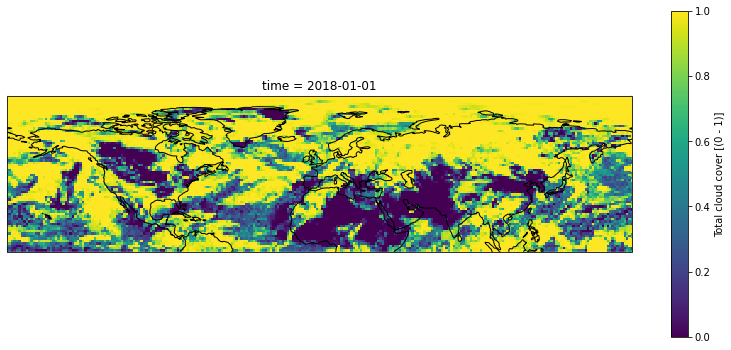

In [5]:
#plot for total cloud cover data
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
cloud_cover_data.tcc[0].plot.pcolormesh(
    ax=ax,x="lon", y="lat", transform=ccrs.PlateCarree(), add_colorbar=True
)
ax.coastlines()
ax.set_ylim([0, 90]);

In [6]:
#totdal data
cloud_cover_data_all=xr.open_mfdataset(path+'total_cloud_cover_1.40625deg/*.nc',combine='by_coords')
cloud_cover_data_all

total_precep_data_all=xr.open_mfdataset(path+'total_precipitation_1.40625deg/*.nc',combine='by_coords')
total_precep_data_all

<xarray.Dataset>
Dimensions:  (lon: 256, lat: 128, time: 350633)
Coordinates:
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -89.3 -87.89 -86.48 -85.08 ... 85.08 86.48 87.89 89.3
  * time     (time) datetime64[ns] 1979-01-01T07:00:00 ... 2018-12-31T23:00:00
Data variables:
    tp       (time, lat, lon) float32 dask.array<chunksize=(8753, 128, 256), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-01 16:44:41 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

In [7]:
#merge the variables from both the dataset
dataset = xr.merge([cloud_cover_data_all, total_precep_data_all])

#  #subset of training data
ds_train = dataset.sel(time=slice('2014','2018'))

/home/prabhakaran/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [8]:
#clip the data 50:50 (positive and negative samples)
def rectangularclipbox(ds, patch_type):

    if patch_type == "positive":
       return ds_train.sel(lat=slice(0,90), lon=slice(0,180))
    else:
        return ds_train.sel(lat=slice(0,90), lon=slice(180,360))



positive_patches = rectangularclipbox(ds_train,"positive")
positive_patches

negative_patches = rectangularclipbox(ds_train,"negative")
negative_patches


#plot to look at patches
# plt.figure(figsize=(14, 6))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# negative_patches.tcc[20].plot.pcolormesh(
#     ax=ax,x="lon", y="lat", transform=ccrs.PlateCarree(), add_colorbar=True
# )
# ax.coastlines()
# ax.set_ylim([0, 90]);


<xarray.Dataset>
Dimensions:  (time: 43824, lat: 64, lon: 128)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 ... 2018-12-31T23:00:00
  * lat      (lat) float64 0.7031 2.109 3.516 4.922 ... 85.08 86.48 87.89 89.3
  * lon      (lon) float64 180.0 181.4 182.8 184.2 ... 354.4 355.8 357.2 358.6
Data variables:
    tcc      (time, lat, lon) float32 dask.array<chunksize=(8760, 64, 128), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(8760, 64, 128), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-01 13:38:30 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

In [9]:
vars = ['tcc','tp']

In [10]:

class WeatherDataset(Dataset):
    def __init__(self, ds, vars):

        self.ds = ds
        self.vars = vars

        data = []
        for var in vars:
            data.append(ds[var])

        self.data = xr.concat(data, 'channel').transpose('channel','time','lat', 'lon')
        self.n_samples = self.data.shape[1]


    def __len__(self):

        return self.n_samples

    def __getitem__(self, i):

        X = self.data.isel(time=i).values
        return X


In [11]:
# load dataset (full dataset, positive patches & negative patches)

weather_train_dataset = WeatherDataset(
    ds_train, vars)

positive_patch_dataset = WeatherDataset(
    positive_patches, vars)

negative_patch_dataset =WeatherDataset(
    negative_patches, vars)

positive_patch_dataset.n_samples

43824

In [12]:
#Dataloader with batch size 128
weather_train_dl= DataLoader(weather_train_dataset, 128, True)

positive_patches_dl= DataLoader(positive_patch_dataset, 128, True)

negative_patches_dl= DataLoader(negative_patch_dataset, 128, True)

In [13]:
batch1 = next(iter(positive_patches_dl))
batch2 = next(iter(negative_patches_dl))

In [19]:
#Pass parameter as false to get the result as distance vector
siamese_net = SiameseNetwork(True)
siamese_net
# to extract features
f1, f2 = siamese_net(batch1, batch2)
f1,f2
# to extract distance vector between features
#out = siamese_net(batch1, batch2)

(tensor([[-0.4655,  0.2964, -0.4541,  ..., -0.6486,  0.2009, -0.8618],
         [ 0.0555, -0.8626, -0.4541,  ..., -0.6486,  1.0734, -0.1087],
         [-0.4655, -0.8626,  0.3788,  ..., -0.6486, -0.6416,  3.1533],
         ...,
         [-0.4655, -0.8626, -0.0964,  ...,  0.7651,  1.3739, -0.8618],
         [-0.1772, -0.8626, -0.4541,  ..., -0.6486, -0.6416, -0.0927],
         [-0.4655, -0.8626, -0.4541,  ..., -0.6486,  1.5964, -0.3485]],
        grad_fn=<NativeBatchNormBackward0>),
 tensor([[-0.0624, -0.7679, -0.5060,  ..., -0.6139, -0.5824, -0.8774],
         [-0.7698, -0.7679,  0.1076,  ..., -0.6139, -0.5824, -1.0267],
         [-0.1471,  1.5393,  1.2208,  ..., -0.6139, -0.5824,  0.9252],
         ...,
         [-0.5367, -0.7679,  1.1594,  ...,  0.5174,  0.6806,  2.6003],
         [ 1.9137, -0.2590, -0.5060,  ..., -0.6139, -0.5824,  1.8301],
         [-0.2536, -0.1962, -0.5060,  ...,  2.3578, -0.5824, -1.0267]],
        grad_fn=<NativeBatchNormBackward0>))